# Statistical analysis

---

In [1]:
import os
import sys
import glob
import logging
import time

import matplotlib.pyplot as plt
import plotly.express as px

import numpy as np
import pandas as pd
from clustergram import Clustergram as CGram
from itertools import combinations

import scipy
from scipy import signal
from scipy import stats

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression as LR

# Data frames combining

In [3]:
samp_list = ['C0002', 'D0001', 'E0002']
data_path = os.path.join(''.join(sys.path[0].split('glia')), 'data_glia')

components_df_list = []
peaks_df_list = []
for samp_to_upload in samp_list:
    samp_upload_path = f'{data_path}/{samp_to_upload}'
    components_df_list.append(pd.read_csv(f'{samp_upload_path}/components_df.csv'))
    peaks_df_list.append(pd.read_csv(f'{samp_upload_path}/peaks_properties_df.csv'))
    print(samp_upload_path)

total_component_df = pd.concat(components_df_list)
total_component_df.to_csv(f'{data_path}/total_components_df.csv')

total_peak_df = pd.concat(peaks_df_list)
total_peak_df.to_csv(f'{data_path}/total_peaks_properties_df.csv')

/home/wisstock/bio/scripts/microca/data_glia/C0002
/home/wisstock/bio/scripts/microca/data_glia/D0001
/home/wisstock/bio/scripts/microca/data_glia/E0002


# Preprocessing

#### DF uploading

In [18]:
samp_list = ['C0002', 'D0001', 'E0002']
data_path = os.path.join(''.join(sys.path[0].split('glia')), 'data_glia')

total_component_df = pd.read_csv(f'{data_path}/total_components_df.csv')
print(total_component_df.head())

total_peak_df = pd.read_csv(f'{data_path}/total_peaks_properties_df.csv')
print(total_peak_df.head())

  reg_name  frame_num      time  comp  profile_raw   profile_C  profile_ddf
0    C0002          0  0.000000     0    53.587025 -161.175541     0.019450
1    C0002          1  1.091983     0    52.102883 -161.175541     0.005571
2    C0002          2  2.183965     0    51.916756 -161.175541    -0.006909
3    C0002          3  3.275948     0    52.376493 -161.175541     0.023312
4    C0002          4  4.367931     0    53.452555 -161.175541     0.028068


### DF sorting

#### Mark profiles inactive in ctrl period 

In [65]:
sort_peaks_df = total_peak_df.copy()
groups = sort_peaks_df.comp.unique()

no_ctrl_comp = {}
for s in range(len(samp_list)):
    s_val = samp_list[s]
    comps = []
    for g in range(len(groups)):
        g_val = groups[g]
        df = sort_peaks_df[(sort_peaks_df['sample'] == s_val) & (sort_peaks_df['comp'] == g_val)]
        app_val = list(df.app_group.unique())
        if app_val:
            if 'ctrl' in app_val:
                continue
            else:
                comps.append(g_val)
                print(s_val, g_val, df.shape, app_val)
        else:
            continue
    no_ctrl_comp.update({s_val:comps})

C0002 1 (1, 12) ['C5a']
C0002 15 (5, 12) ['C5a', 'wash']
C0002 16 (1, 12) ['C5a']
D0001 5 (2, 12) ['wash']
D0001 11 (4, 12) ['wash']
D0001 14 (6, 12) ['C5a', 'wash']
E0002 15 (2, 12) ['wash']
E0002 16 (8, 12) ['C5a', 'wash']
E0002 14 (4, 12) ['C5a', 'wash']


In [73]:
print(total_peak_df.shape)
print(total_component_df.shape)

(604, 12)
(99000, 7)


#### No ctrl DF creation

In [68]:
no_ctrl_peaks_df = []
no_ctrl_prof_df = []
for samp in samp_list:
    sel_prof = no_ctrl_comp[samp]
    no_ctrl_peaks_df.append(total_peak_df[(total_peak_df['sample'] == samp) & (total_peak_df['comp'].isin(sel_prof))])
    no_ctrl_prof_df.append(total_component_df[(total_component_df['reg_name'] == samp) & (total_component_df['comp'].isin(sel_prof))])

no_ctrl_peaks_df = pd.concat(no_ctrl_peaks_df)
no_ctrl_prof_df = pd.concat(no_ctrl_prof_df)

print(no_ctrl_peaks_df.shape)
print(no_ctrl_prof_df.shape)

(33, 12)
(15000, 7)


#### Ctrl DF creation

In [72]:
ctrl_peaks_df = total_peak_df.copy()
ctrl_prof_df = total_component_df.copy()

ctrl_peaks_df = ctrl_peaks_df.drop(index=list(no_ctrl_peaks_df.index))
ctrl_prof_df = ctrl_prof_df.drop(index=list(no_ctrl_prof_df.index))

print(ctrl_peaks_df.shape)
print(ctrl_prof_df.shape)

(571, 12)
(84000, 7)


# Descriptive stat.

### Pairwise KS-test

In [ ]:
stat_param = 'amp_dF'

#### No ctrl profiles

In [63]:
groups = no_ctrl_peaks_df.app_group.unique()
groups_combinations = list(combinations(groups, 2))

for samp in samp_list:
    samp_df = no_ctrl_peaks_df[no_ctrl_df['sample'] == samp]
    print(f'Sample {samp}')
    for g_comb in groups_combinations:
        group_1 = samp_df[stat_param][samp_df['app_group'] == g_comb[0]]
        group_2 = samp_df[stat_param][samp_df['app_group'] == g_comb[1]]
        ks_test = stats.ks_2samp(group_1, group_2)
        print(f'KS test for {g_comb} groups, p-value={ks_test[1]}')
    print('')

Sample C0002
KS test for ('C5a', 'wash') groups, p-value=0.09523809523809523

Sample D0001
KS test for ('C5a', 'wash') groups, p-value=0.3333333333333333

Sample E0002
KS test for ('C5a', 'wash') groups, p-value=0.30769230769230765



/tmp/ipykernel_20152/404121007.py:7: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [64]:
# https://towardsdatascience.com/comparing-sample-distributions-with-the-kolmogorov-smirnov-ks-test-a2292ad6fee5
fig = px.ecdf(no_ctrl_peaks_df,
              x=stat_param,
              color='app_group',
              animation_frame='sample')
fig.show()

fig = px.histogram(no_ctrl_peaks_df,
              x=stat_param,
              color='app_group',
              animation_frame='sample',
              marginal='box',
              opacity=0.75)
fig.show()

#### Ctrl profiles

In [74]:
groups = ctrl_peaks_df.app_group.unique()
groups_combinations = list(combinations(groups, 2))

for samp in samp_list:
    samp_df = ctrl_peaks_df[ctrl_peaks_df['sample'] == samp]
    print(f'Sample {samp}')
    for g_comb in groups_combinations:
        group_1 = samp_df[stat_param][samp_df['app_group'] == g_comb[0]]
        group_2 = samp_df[stat_param][samp_df['app_group'] == g_comb[1]]
        ks_test = stats.ks_2samp(group_1, group_2)
        print(f'KS test for {g_comb} groups, p-value={ks_test[1]}')
    print('')
    print('')

Sample C0002
KS test for ('ctrl', 'C5a') groups, p-value=0.3472258786959526
KS test for ('ctrl', 'wash') groups, p-value=0.2779570292596386
KS test for ('C5a', 'wash') groups, p-value=0.9282546824423102


Sample D0001
KS test for ('ctrl', 'C5a') groups, p-value=0.3500297587761064
KS test for ('ctrl', 'wash') groups, p-value=0.2889770690630442
KS test for ('C5a', 'wash') groups, p-value=0.005465063712677011


Sample E0002
KS test for ('ctrl', 'C5a') groups, p-value=0.375982705124828
KS test for ('ctrl', 'wash') groups, p-value=0.29944282343681644
KS test for ('C5a', 'wash') groups, p-value=0.584916237791796




In [75]:
fig = px.ecdf(ctrl_peaks_df,
              x=stat_param,
              color='app_group',
              animation_frame='sample')
fig.show()

fig = px.histogram(ctrl_peaks_df,
              x=stat_param,
              color='app_group',
              animation_frame='sample',
              marginal='box',
              opacity=0.75)
fig.show()

# Dim. reduction and clasterization

In [85]:
work_df = ctrl_peaks_df.copy()

feature_col_list = ['rise', 'decay', 'FWHM', 'AUC_dF', 'amp_dF']
factor_col_list = ['sample', 'comp', 'app_group']

#### Features importance estimation

PCA()


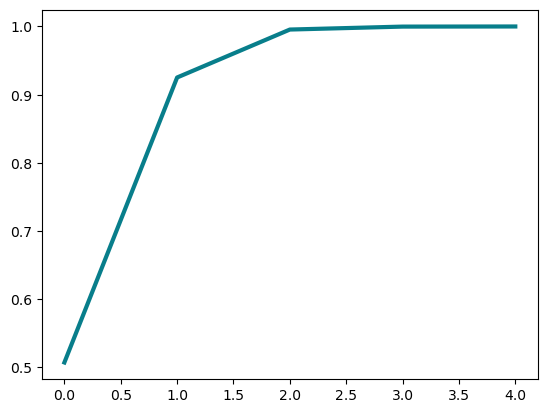

In [76]:
# https://python-bloggers.com/2021/01/3-essential-ways-to-calculate-feature-importance-in-python/
# https://stackoverflow.com/questions/50796024/feature-variable-importance-after-a-pca-analysis

test_features_vals = work_df[feature_col_list].values

test_pca = PCA()
test_features_pca = test_pca.fit(X=test_features_vals)

print(test_features_pca)

plt.plot(test_features_pca.explained_variance_ratio_.cumsum(), lw=3, color='#087E8B')
plt.show()


## PCA

#### Features estimation

[[ 0.55987952  0.82599118]
 [ 0.80864734 -0.56191013]
 [ 0.03926402 -0.00941901]
 [ 0.17620361 -0.043633  ]
 [ 0.00591812 -0.00173974]]


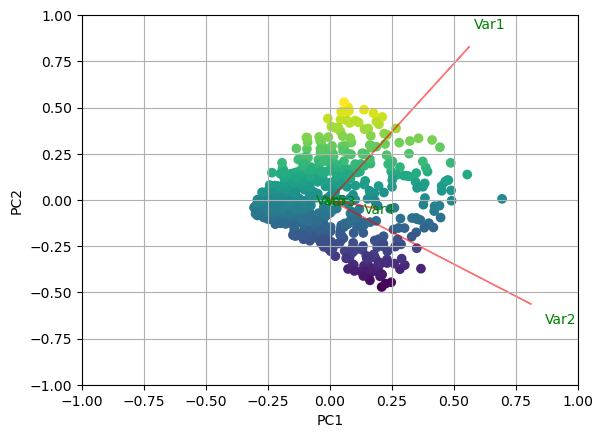

In [84]:
# https://stackoverflow.com/questions/50796024/feature-variable-importance-after-a-pca-analysis

def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley, c = ys)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')


features = work_df[feature_col_list].values
pca = PCA()
principal = pca.fit_transform(features)

print(np.transpose(pca.components_[0:2, :]))

plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))
plt.grid()
myplot(principal[:,0:2], np.transpose(pca.components_[0:2, :]))
plt.show()

#### PCA calc

In [86]:
def PCA_calc(features_vals, factor_df, n=2):
    tic = time.perf_counter()

    if n == 2:
        ax_list = ['x', 'y']
    elif n == 3:
        ax_list = ['x', 'y', 'z']
    else:
        logging.fatal('Incorrect dimension number!')

    pca = PCA(n_components=n)
    principal_res = pca.fit_transform(features_vals)
    df_principal = pd.DataFrame(data = principal_res,
                                columns = ax_list)
    df_principal = pd.concat([factor_df, df_principal], axis = 1)

    toc = time.perf_counter()
    logging.info(f'PCA calc in {toc - tic:0.4f} seconds')
    return df_principal

n_components = 3
features_vals = work_df[feature_col_list].values
factor_df = work_df[factor_col_list]

pca_df = PCA_calc(features_vals=features_vals, factor_df=factor_df, n=n_components)

#### PCA plot

In [87]:
group_factor = 'app_group'

if n_components == 2:
    fig = px.scatter(pca_df,
                     x='x', y='y',
                     color=group_factor,
                     symbol=group_factor)
    dot_size = 6
elif n_components == 3:
    fig = px.scatter_3d(pca_df,
                        x='x', y='y', z='z',
                        color=group_factor,
                        symbol=group_factor)
    dot_size = 2
else:
    logging.fatal('Incorrect n')

fig.update_traces(marker=dict(size=8,
                              line=dict(width=2,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0),
                  legend= {'itemsizing': 'constant'},
                  scene=dict(xaxis=dict(showaxeslabels=False, showticklabels=False, showbackground=False, title=''),
                             yaxis=dict(showaxeslabels=False, showticklabels=False, showbackground=False, title=''), 
                             zaxis=dict(showaxeslabels=False, showticklabels=False, showbackground=False, title='')))
fig.show()

## LDA

#### LDA calc

In [88]:
def LDA_calc(features_vals, factor_df, group_column=None):
    tic = time.perf_counter()

    group_vals = factor_df.loc[:,group_column].values

    lda = LDA()
    lda_fit = lda.fit_transform(X=features_vals, y=group_vals)
    df_lda = pd.DataFrame({'lda1':lda_fit[:,0], 'lda2':lda_fit[:,1]})
    df_lda = pd.concat([factor_df, df_lda], axis = 1)

    toc = time.perf_counter()
    logging.info(f'PCA calc in {toc - tic:0.4f} seconds')
    return df_lda

features_vals = work_df[feature_col_list].values
factor_df = work_df[factor_col_list]
lda_df = LDA_calc(features_vals=features_vals, factor_df=factor_df, group_column='app_group')


print(lda_df.head())

# plotting
# fig = px.box(lda_df, x="app_group", y="lda", color='app_group', points='all')
fig = px.scatter(lda_df, x="lda1", y="lda2", color='app_group', symbol='app_group', width=700, height=500)

fig.update_traces(marker=dict(size=12,
                              line=dict(width=2,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))

fig.show()

  sample  comp app_group      lda1      lda2
0  C0002   0.0      ctrl -0.652355  1.230962
1  C0002   0.0      ctrl  0.276538  0.543102
2  C0002   0.0      ctrl -1.130058  0.716101
3  C0002   0.0      ctrl -0.058700  0.434058
4  C0002   0.0      ctrl -0.931150 -0.003209


## Clustergram

In [91]:
cgram = CGram(range(1, 10), n_init=1000)

cgram.fit(work_df[feature_col_list])

K=1 skipped. Mean computed from data directly.
K=2 fitted in 1.7650501728057861 seconds.
K=3 fitted in 1.792292594909668 seconds.
K=4 fitted in 1.762009620666504 seconds.
K=5 fitted in 1.979600191116333 seconds.
K=6 fitted in 2.402402400970459 seconds.
K=7 fitted in 2.223613977432251 seconds.
K=8 fitted in 2.5536320209503174 seconds.
K=9 fitted in 2.5706470012664795 seconds.


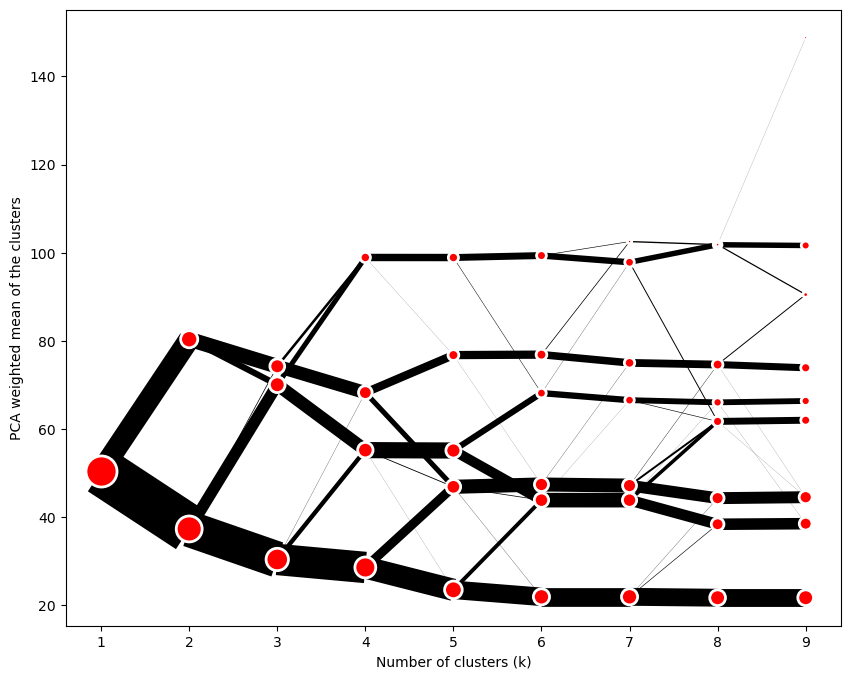

In [92]:
ax = cgram.plot(figsize=(10, 8))
ax.yaxis.grid(False)